In [1]:
### using Lorenz and Harmann eq(1) final_m_term, which is -1/cos**2 * d(<[\bar{u'v'}]> * cos^2)/dy equal to m
import numpy as np
import matplotlib.pyplot as plt
import h5py
import multiprocessing
from multiprocessing import Pool
import os
import matplotlib.cm as cm

In [2]:
class Dycore:
    def __init__(self, file):
        self.ds = h5py.File(file, "r")
        
    def getVar(self, var):
        return np.asarray(self.ds[var])

In [3]:
from scipy.fftpack import fft,ifft,fftfreq
file  = f"HS_front_RH50_PR0_PRRELAX86400_with_w_all.dat" # ./outputs/withprecip/

dycore = Dycore(file)
u  = dycore.getVar("grid_u_c_xyzt")
v  = dycore.getVar("grid_v_c_xyzt")
t  = dycore.getVar("grid_t_c_xyzt")
ps = dycore.getVar("grid_ps_xyzt")
p  = dycore.getVar("grid_p_full_xyzt")
sigma = p / ps
sigma_mean  = np.nanmean(sigma, axis=(0,3))
sigma_onlyz = np.nanmean(sigma_mean, axis=1)
Rd = 287
cp = 1004
g = 9.81
theta      = t * (ps / p)**(Rd/cp)
H = 6800
a = 6.37122e6

In [4]:
Vzm = np.nanmean(v, axis=3)
Uzm = np.nanmean(u, axis=3)
Vza = np.zeros(u.shape)
Uza = np.zeros(u.shape)

x = np.linspace(-180,180,128)
y = np.linspace(-90,90,64)
xd = np.deg2rad(x)
yd = np.deg2rad(y)


(500, 64)
0.00014459464953348408
251.81037942236006
[           nan 6.31711473e-05 1.58321235e-05 7.06575391e-06
 3.99766273e-06 2.57772768e-06 1.80656887e-06 1.34175749e-06
 1.04025819e-06 8.33740023e-07 6.86215013e-07 5.77266961e-07
 4.94614641e-07 4.30511579e-07 3.79876480e-07 3.39264921e-07
 3.06275950e-07 2.79195428e-07 2.56774025e-07 2.38084793e-07
 2.22429313e-07 2.09274414e-07 1.98208603e-07 1.88911534e-07
 1.81132271e-07 1.74673609e-07 1.69380654e-07 1.65132437e-07
 1.61835756e-07 1.59420671e-07 1.57837267e-07 1.57053426e-07
 1.57053426e-07 1.57837267e-07 1.59420671e-07 1.61835756e-07
 1.65132437e-07 1.69380654e-07 1.74673609e-07 1.81132271e-07
 1.88911534e-07 1.98208603e-07 2.09274414e-07 2.22429313e-07
 2.38084793e-07 2.56774025e-07 2.79195428e-07 3.06275950e-07
 3.39264921e-07 3.79876480e-07 4.30511579e-07 4.94614641e-07
 5.77266961e-07 6.86215013e-07 8.33740023e-07 1.04025819e-06
 1.34175749e-06 1.80656887e-06 2.57772768e-06 3.99766273e-06
 7.06575391e-06 1.58321235e-05 6.

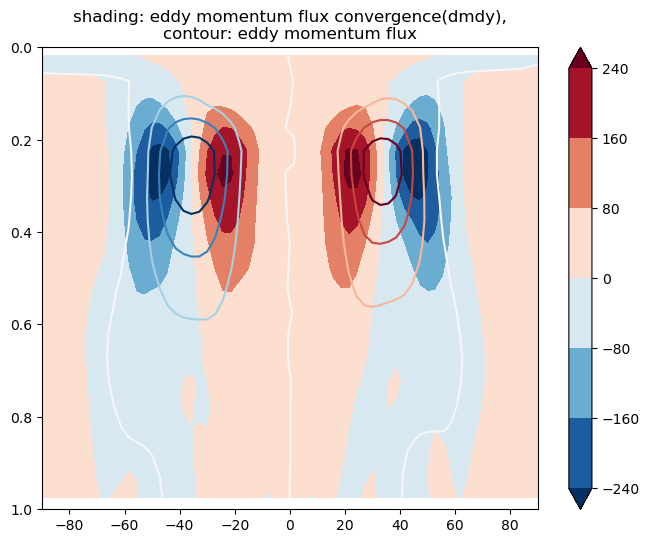

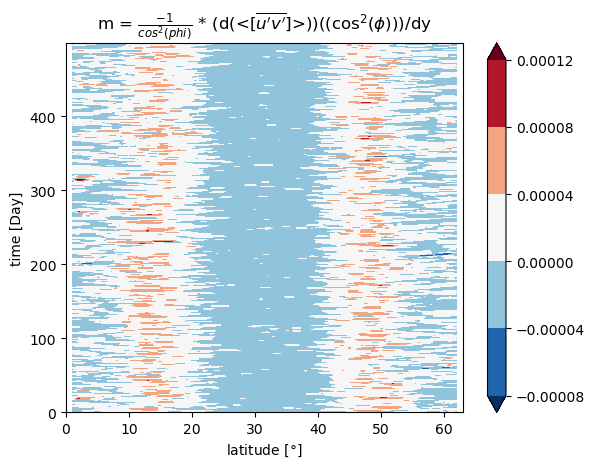

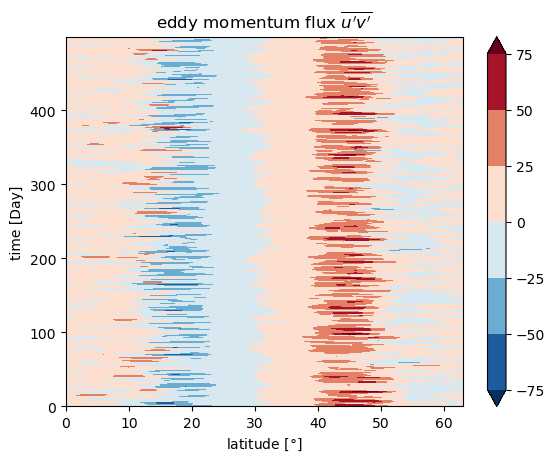

In [5]:
for i in range(0,128):
    Vza[:,:,:,i]     = v[:,:,:,i] - Vzm
    Uza[:,:,:,i]     = u[:,:,:,i] - Uzm   

momentum = np.nanmean(Uza[:,:,:,:] * Vza[:,:,:,:], axis=(1,3))
cy = np.cos(yd)
cy [0] = np.nan
cy [-1] = np.nan
acy_square = a * cy ** 2

cm  = np.zeros((500,64))
for i in range(64):
    cm[:,i] = cy[i]**2 * momentum[:,i]
pmpu = np.zeros((500,64))
for i in range(2,64-2):
    pmpu[:,i] = (cm[:,i+1] - cm[:,i-1]) / (yd[i+1] - yd[i-1])

# pmpu[:, 0] = (cm[:, 1] - cm[:, 0]) / (yd[ 1] - yd[ 0])
# pmpu[:,-1] = (cm[:,-1] - cm[:,-2]) / (yd[-1] - yd[-2])
# print(np.nanmax(pmpu))
# print(pmpu)
final_m_term = np.zeros((500,64))
for i in range(64):
    final_m_term[:,i] = - pmpu[:,i] / acy_square[i]
print(final_m_term.shape)
print(np.nanmax(final_m_term))
print(np.nanmax(pmpu))
print(1 / acy_square)

### plot for check 
sigma_mean = np.nanmean(p/ps, axis=(0,3))
sigma_onlyz = np.nanmean(sigma_mean, axis=1)
y = np.linspace(-90,90,64)
yy, sigma_mean2 = np.meshgrid(y,sigma_onlyz)
#
check = np.zeros((20,64))
kk = np.nanmean(Uza * Vza, axis=(0,3))
for i in range(1,64-1):
    check[:,i] = (kk[:,i+1] - kk[:,i-1]) / (yd[i+1] - yd[i-1])
check[:, 0] = (kk[:, 1] - kk[:, 0]) / (yd[ 1] - yd[ 0])
check[:,-1] = (kk[:,-1] - kk[:,-2]) / (yd[-1] - yd[-2])
plt.figure(figsize=(8,6), dpi=100)
CS = plt.contourf(yy[:,:], sigma_mean2[:,:], check, cmap="RdBu_r", extend="both")
plt.contour(yy[:,:], sigma_mean2[:,:], np.nanmean(Uza* Vza, axis=(0,3)), cmap="RdBu_r", extend="both")
plt.ylim([1,0])
plt.colorbar(CS)
plt.title("shading: eddy momentum flux convergence(dmdy),\ncontour: eddy momentum flux", fontsize=12) 
plt.savefig(r"paper1_fig/Lorenz and Harmann eq(1)_fig/RH50_PR10//eddy momentum flux.png", bbox_inches='tight', dpi=600.)
plt.show()

plt.figure()
CS = plt.contourf(final_m_term, cmap="RdBu_r", extend="both")
plt.title(r"m = $\frac{-1}{cos^2(phi)}$ * (d(<[$\overline{u'v'}$]>))(($\cos^2$($\phi$)))/dy ")
plt.colorbar(CS)
plt.xlabel("latitude [$\degree$]")
plt.ylabel("time [Day]")
plt.savefig(r"paper1_fig/Lorenz and Harmann eq(1)_fig/RH50_PR10//m with time and latitude.png", bbox_inches='tight', dpi=600.)
plt.show()

plt.figure()
CS2 = plt.contourf(momentum, cmap="RdBu_r", extend="both")
plt.title("eddy momentum flux $\overline{u'v'}$")
plt.colorbar(CS2)
plt.xlabel("latitude [$\degree$]")
plt.ylabel("time [Day]")
plt.savefig(r"paper1_fig/Lorenz and Harmann eq(1)_fig/RH50_PR10//eddy momentum flux with time and latitude.png", bbox_inches='tight', dpi=600.)
plt.show()

In [6]:
from numpy import linalg 
u_50 = dycore.getVar("grid_u_c_xyzt")
u_50 = np.nanmean(u_50[:,:,:,:], axis=(1,3))

# try_50_low, _, EOF_50_low =  np.linalg.svd(u_50[:,:])
# z = try_50_low[:,0]
# Z = fft(z) / len(z)    #要除以資料長度
# # print(final_m_term.shape)
# mm = np.dot(final_m_term[:,2:-2],EOF_50_low[0,2:-2].T)
# print(final_m_term[:,2:-2].shape)
# print(EOF_50_low[0,2:-2].T.shape)
def normalize(arr):
    std   = np.std(arr)
    final = arr / std
    return final, std 

# # assign array and range
# range_to_normalize = (-1, 1)
# m,std  = normalize(mm)
# plt.figure()
# plt.plot(m)

# new_EOF = std * EOF_50_low
# plt.figure()
# plt.plot(try_50_low[0,:])



# # print(EOF_50_low.shape)
# # print(final_m_term.shape)
# print(mm.shape)
# # print(final_m_term[:,2:-2])
# # print(m)
# M = fft(m) / len(m)

# freq = fftfreq(u.shape[0])
# idx = np.argsort(freq)

# M_star = np.conjugate(M)
# Z_star = np.conjugate(Z)

# final = (Z_star * M) / (Z_star * Z)
# # plt.figure(dpi=100.)
# kk = 350
# ll = 250
# print(final.shape)
# print(final.T.real[idx].shape)
# # plt.plot(freq[idx][ll:kk],final.T.real[idx][ll:kk], label="real")
# # plt.plot(freq[idx][ll:kk],final.T.imag[idx][ll:kk], label="imginary")
# # plt.plot(freq[idx][ll:kk],freq[idx][ll:kk] * 2* np.pi, label="2 * pi * freq")


# plt.plot(Z_star.real[0:250], label="real")
# plt.figure(dpi=100.)
# plt.plot(freq[1:250],Z.real[1:250], label="real")
# plt.plot(freq[1:250],Z.imag[1:250], label="imginary")
# slope = np.polyfit(freq[kk:], final[kk:].imag, 1)[:]
# print(slope)
# y = slope[0] * freq[:kk] + slope[1] * freq[:kk]
# print(y)
# plt.plot(freq[idx][kk:], y[idx][kk:], label="polyfit")
# plt.legend()
# test = np.zeros((500,64,64))
# for i in range(0, 2):
#     test[:,:,i] = np.dot(np.reshape(try_50_low[:,i],[500,1]), np.reshape(EOF_50_low[i,:],[1,64]))
# plt.figure()
# plt.contourf(u_50,5)
# plt.figure()
# plt.contourf(test.sum(axis=2))

In [7]:
plt.figure(dpi=100.)
plt.plot(freq[1:kk],(Z*Z_star).real[1:kk], label="real")
# plt.plot(freq[1:kk],(Z*Z_star).imag[1:kk], label="imginary")
plt.legend()

plt.figure(dpi=100.)
plt.plot(freq[1:kk],(M*M_star).real[1:kk], label="real")
plt.plot(freq[1:kk],(M*M_star).imag[1:kk], label="imginary")
plt.legend()

NameError: name 'freq' is not defined

<Figure size 640x480 with 0 Axes>

In [8]:
print((1+1j) * (2+3j) /  ((1-1j) * (1+1j)) )
print((1+1j) * (2+3j))
print(((1-1j) * (1+1j)))

(-0.5+2.5j)
(-1+5j)
(2+0j)


7.90895936070087
5.42054448398379e-05


Text(0.5, 1.0, 'Checking the relationship between m and z signal')

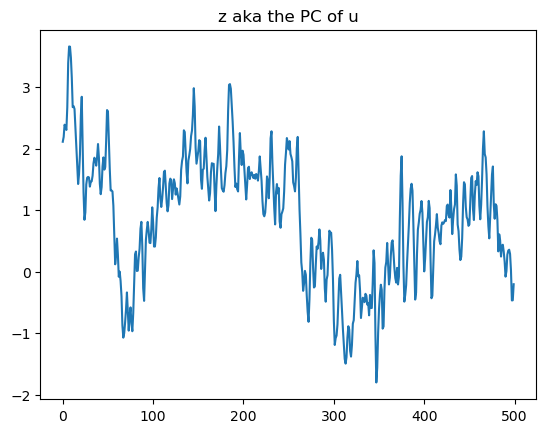

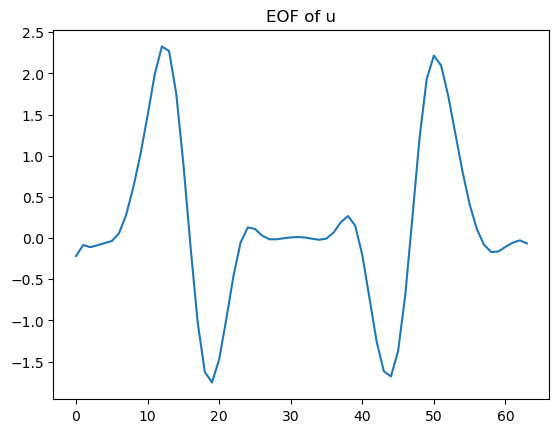

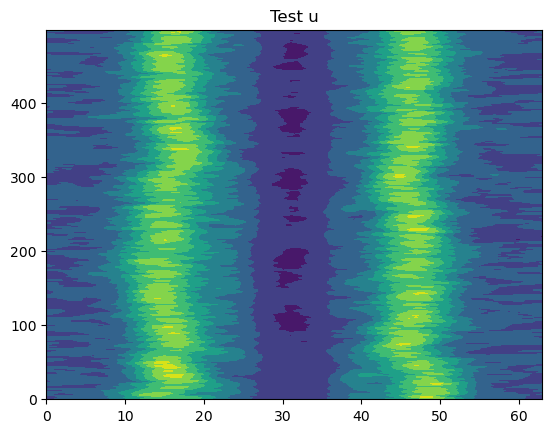

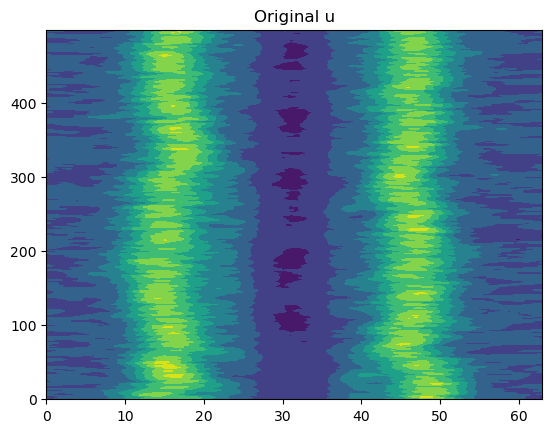

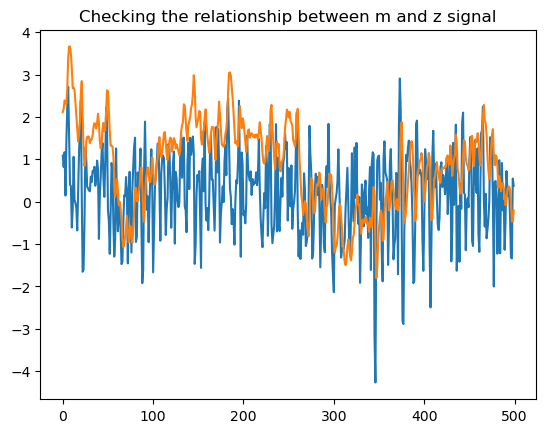

In [59]:
from EOF import EOF
from scipy.fft import fft, ifft

u_50 = dycore.getVar("grid_u_c_xyzt")
for i in range(1,64-1): # cy[0] and [-1] are np.nan
    u_50[:,:,i,:] = u_50[:,:,i,:] * (cy[i])**0.5
u_50 = np.nanmean(u_50[:,:,:,:], axis=(1,3))

single_EOF_50 =  EOF((u_50[:,:],), n_components=64, field="1D")
single_EOF_50.get()

z       = (single_EOF_50.PC[0,:])
EOF_try = (single_EOF_50.EOF[0,:])

z_std = z.std()
print(z_std)
z     = z / z_std 
plt.figure()
plt.plot(z)
plt.title("z aka the PC of u") 


EOF_try = EOF_try * z_std
plt.figure()
plt.plot(EOF_try)
plt.title("EOF of u") 

print(np.nanmax(final_m_term))
for i in range(1,64-1): # cy[0] and [-1] are np.nan
    final_m_term[:,i] = final_m_term[:,i] * (cy[i])**0.5
m       = np.dot(EOF_try[2:-2], final_m_term[:,2:-2].T)
# m = m * 30 * 86400 /np.pi
m = m / np.std(m)
plt.figure()
plt.contourf((single_EOF_50.EOF.T.dot(single_EOF_50.PC)).T)
plt.title("Test u") 

plt.figure()
plt.contourf(u_50)
plt.title("Original u") 

plt.figure()
plt.plot(m)
plt.plot(z)

plt.title("Checking the relationship between m and z signal") 


(7.349870081249799+0j)
(0.2123264227861163+0j)
(0.3535885377056731+0j)
[ 0.02888846+0.j          0.05994052+0.0338175j   0.07637683+0.18006997j
  0.00776794+0.22264162j  0.03377517+0.3143247j  -0.03206489+0.40951819j
  0.00948552+0.37356014j -0.02109681+0.4073585j  -0.54490432+0.01962734j
  0.32914111+0.44673087j -0.47567561+0.3963906j   0.3077188 +0.55570846j
  0.18359904+1.71041j    -0.17020519-0.03231971j -0.83273628-0.29904621j
  0.35358854+0.j         -0.83273628+0.29904621j -0.17020519+0.03231971j
  0.18359904-1.71041j     0.3077188 -0.55570846j -0.47567561-0.3963906j
  0.32914111-0.44673087j -0.54490432-0.01962734j -0.02109681-0.4073585j
  0.00948552-0.37356014j -0.03206489-0.40951819j  0.03377517-0.3143247j
  0.00776794-0.22264162j  0.07637683-0.18006997j  0.05994052-0.0338175j ]


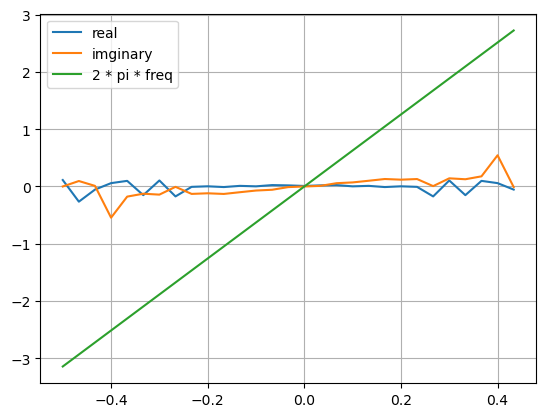

In [64]:
# z = z * z_std
# m = m * z_std
# Do not take the all time series to do FFT,
# there would be offset. So I'm gotta to take the small time interval to do FFT, 
# which are overlap (because after FFT, there would be a pulse at both ends of the spectrum space.
lg = 30 # length of interval 
Z_sum   = np.zeros(lg, dtype = complex)
M_sum   = np.zeros(lg, dtype = complex)

for i in range(0 , len(z), lg):
    if i == 0:
        aa = i
        Z_sum += fft(z[0:aa+lg])  / len(z[0:aa+lg])     #要除以資料長度
        M_sum += fft(m[0:aa+lg])  / len(m[0:aa+lg])
    else:
        aa = int(i-15)   
        Z_sum += fft(z[aa:aa+lg]) / len(z[aa:aa+lg])    #要除以資料長度
        M_sum += fft(m[aa:aa+lg]) / len(m[aa:aa+lg])
        # print(np.nanmin(Z_sum))
    
# print((len(Z) / lg))
Z = Z_sum / (len(z) / lg)
M = M_sum / (len(m) / lg)
print(np.nanmax(Z))
print(np.nanmax(M))
# print(Z_final)

freq = fftfreq(Z.shape[0])
idx = np.argsort(freq)

M_star = np.conjugate(M)
Z_star = np.conjugate(Z)

final = (Z_star * M) / (Z_star * Z)
print(final.max())
kk = -1 #int(lg)
ll = 0 #int(lg/2-2)
print(final)
plt.figure(dpi=100.)
plt.plot(freq[idx][ll:kk],(final[idx][ll:kk]).real / np.pi, label="real")
plt.plot(freq[idx][ll:kk],(final[idx][ll:kk]).imag/ np.pi, label="imginary")
plt.plot(freq[idx][ll:kk],freq[idx][ll:kk] * 2* np.pi, label="2 * pi * freq")
# plt.plot(freq[idx],(final).real, label="real")
# plt.plot(freq[idx],(final).imag, label="imginary")
# plt.xlim([-0.01, 0.25])
# plt.ylim([-0.05,1.75])
plt.grid()
plt.legend()
plt.savefig(r"paper1_fig/Lorenz and Harmann eq(1)_fig/RH50_PR10//cross_spectrum.png", bbox_inches='tight', dpi=600.)
plt.show()

In [61]:
x = np.array([0, 1   , 5+4j], dtype = complex)
y = np.array([8, 2+1j, 5+1j], dtype = complex)
print(np.dot(x,y))
print(np.dot(y,x))
print((x+y) / 2)

(23+26j)
(23+26j)
[4. +0.j  1.5+0.5j 5. +2.5j]


(500, 64)
(500, 60)
(60,)
(500, 60)
(64,)


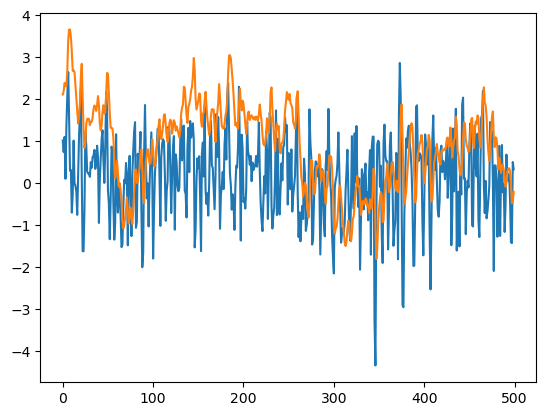

In [62]:
u  = dycore.getVar("grid_u_c_xyzt")
u_50 = np.nanmean(u, axis=(1,3))
print(u_50.shape)
z       = (single_EOF_50.PC[0,:])
EOF_try = (single_EOF_50.EOF[0,:])
print(final_m_term[:,2:-2].shape)
print((np.cos(yd)[2:-2]**0.5).shape)
u_50_test    = final_m_term[:,2:-2] * (np.cos(yd)[2:-2]**0.5).T
print(u_50_test.shape)
print(EOF_try.shape)
z_final_test = np.dot(u_50_test, EOF_try[2:-2])
# print(z_final_test)

plt.figure()
plt.plot(z_final_test.T/np.std(z_final_test.T))
# plt.figure()
plt.plot(z.T/np.std(z.T))